In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
import numpy as np
from sklearn.svm import SVC
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [2]:
df=pd.read_csv('data.csv')

In [3]:
df.head()

,confidence,currentSpeed,currentTravelTime,freeFlowSpeed,freeFlowTravelTime,latitude,local,longitude,transito,record_date
0,1.00000,8,45,8,45,41.546581,Avenida da Liberdade,-8.420194,0.000000,2022-04-06 17:50:00
1,1.00000,47,137,72,89,41.557563,Braga Parque,-8.407298,0.348794,2022-04-06 17:50:00
2,1.00000,75,34,75,34,41.541670,Centro comercial Minho Center,-8.402278,0.000000,2022-04-06 17:50:00
3,1.00000,23,61,36,39,41.548815,Estação de Comboios,-8.433624,0.360883,2022-04-06 17:50:00
4,0.98902,24,160,53,72,41.555693,Meliá,-8.399266,0.542561,2022-04-06 17:50:00


In [4]:
df.describe()

,confidence,currentSpeed,currentTravelTime,freeFlowSpeed,freeFlowTravelTime,latitude,longitude,transito
count,28100.000000,28100.000000,28100.000000,28100.000000,28100.000000,28100.000000,28100.000000,28100.000000
mean,0.992826,41.452705,64.676940,44.877936,57.142456,41.546615,-8.422473,0.088425
std,0.025151,21.444956,40.470082,20.134799,32.903344,0.009469,0.014963,0.179353
min,0.540000,1.000000,6.000000,6.000000,4.000000,41.527837,-8.446202,0.000000
25%,1.000000,24.000000,34.000000,37.000000,34.000000,41.541670,-8.433624,0.000000
50%,1.000000,42.000000,66.000000,42.000000,61.500000,41.547698,-8.424378,0.000000
75%,1.000000,58.000000,89.000000,58.000000,72.000000,41.555693,-8.407298,0.000000
max,1.000000,75.000000,568.000000,75.000000,131.000000,41.559359,-8.399266,0.917785


In [5]:
df.columns

Index(['confidence', 'currentSpeed', 'currentTravelTime', 'freeFlowSpeed',
       'freeFlowTravelTime', 'latitude', 'local', 'longitude', 'transito',
       'record_date'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28100 entries, 0 to 28099
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   confidence          28100 non-null  float64
 1   currentSpeed        28100 non-null  int64  
 2   currentTravelTime   28100 non-null  int64  
 3   freeFlowSpeed       28100 non-null  int64  
 4   freeFlowTravelTime  28100 non-null  int64  
 5   latitude            28100 non-null  float64
 6   local               28100 non-null  object 
 7   longitude           28100 non-null  float64
 8   transito            28100 non-null  float64
 9   record_date         28100 non-null  object 
dtypes: float64(4), int64(4), object(2)
memory usage: 2.1+ MB


In [7]:
df.count()

confidence            28100
currentSpeed          28100
currentTravelTime     28100
freeFlowSpeed         28100
freeFlowTravelTime    28100
latitude              28100
local                 28100
longitude             28100
transito              28100
record_date           28100
dtype: int64

<AxesSubplot:>

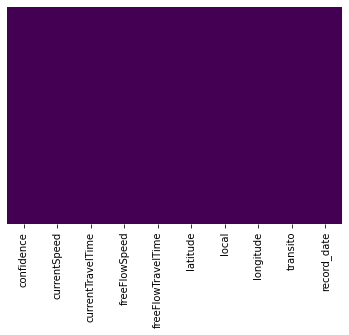

In [8]:
#Verificar campos em falta ou falta de dados
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
#sns.pairplot(df)

<AxesSubplot:>

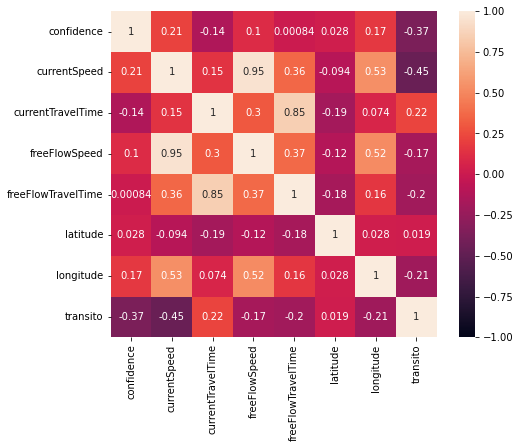

In [10]:
#Correlação
corr_matrix=df.corr()
f,ax= plt.subplots(figsize=(8,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

TRATAMENTO DOS DADOS

In [11]:
#Dados inuteis
#a latitude e longitude dos locais é sempre a mesma por isso acho que basta termos só o local, temos de normalizar o local depois
df.drop(['latitude'],axis=1, inplace=True)
df.drop(['longitude'],axis=1, inplace=True)
#o mesmo se passa com o freeFlow, é sempre a mesma para o mesmo local e já temos o transito calculado, não nos interessa 
df.drop(['freeFlowSpeed'],axis=1, inplace=True)
df.drop(['freeFlowTravelTime'],axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28100 entries, 0 to 28099
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   confidence         28100 non-null  float64
 1   currentSpeed       28100 non-null  int64  
 2   currentTravelTime  28100 non-null  int64  
 3   local              28100 non-null  object 
 4   transito           28100 non-null  float64
 5   record_date        28100 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.3+ MB


In [13]:
#verificar dados com confiança abaixo da ideal (95%)
low_confidence = df[ df['confidence'] < 0.95 ].index
low_confidence

Int64Index([   42,    54,    68,    76,    77,   149,   228,   238,   239,
              279,
            ...
            27229, 27259, 27318, 27319, 27333, 27348, 27357, 27359, 27388,
            27498],
           dtype='int64', length=1278)

In [14]:
#devemos dropar as linhas com baixa confiança para podermos ter os melhores resultados
df.drop(low_confidence , inplace=True)
#e podemos já dropar a coluna da confiança que já não nos vai servir para mais nada
df.drop(['confidence'],axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26822 entries, 0 to 28099
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   currentSpeed       26822 non-null  int64  
 1   currentTravelTime  26822 non-null  int64  
 2   local              26822 non-null  object 
 3   transito           26822 non-null  float64
 4   record_date        26822 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ MB


In [16]:
print(df['currentSpeed'].unique())
print(df['currentTravelTime'].unique())
print(df['local'].unique())
print(df['transito'].unique())

[ 8 47 75 23 24 27 37 29 21  4 31 44 32 36 28 34 42 45 25  6 30 54 13 26
  2 43 12 58 20 38 39 53  7 49 72 41  5 18  9 35 33 14 51 17 50 19 56  3
 16 40 10 59 11 22 46 55 48 15 57 52 61 64 63 69 65 74 60 62 67  1]
[ 45 137  34  61 160 194  92 133  46  29 110 146  67 164 107 100 153  86
  39 169  19 113  47 108 181 149  36  58 150 132 106 117  66  42  70 101
  25 121 120  50 104  33  16  69  89  93  23 103 125  91  52   8  71  56
   6  38  12  14  97  87 131 114 126  82  73  94 128 129  74 115 187 159
 154  90  98  88 102   9  96  40  11  32  99  54 136 175  78 189 179 116
 156 109  10  48 155  31  37  84 162 140 234  57 170 201 142 183 148 202
 213 157 281 210 143 134 352 167 219 469  65 165 250 192 161 239  51 174
 263  44 274 176 292 228 111 124 105  60 138  43 242 309 277 222 215 190
 200 193 227 269 119  72  85  83 276 568 350 147 243 226 240 256 328  49
 262 204 168 375]
['Avenida da Liberdade' 'Braga Parque' 'Centro comercial Minho Center'
 'Estação de Comboios' 'Meliá' 'Rotunda 

In [17]:
'''
Preparação e tratamento de dados
'''

#currentSpeed
#currentTravelTime

#date_time
    #separar data
#df['date_time'] = df['date_time'].str.replace("_", " ")
#df['year'] = pd.to_datetime(df['date_time']).dt.year
df['month'] = pd.to_datetime(df['record_date']).dt.month
df['day'] = pd.to_datetime(df['record_date']).dt.day
    #weekday mete logo em int, segunda=0 e domingo=6
df['week_day'] = pd.to_datetime(df['record_date']).dt.weekday
df['hour'] = pd.to_datetime(df['record_date']).dt.hour
df['minute'] = pd.to_datetime(df['record_date']).dt.minute

    #dropar date_time
df.drop(['record_date'],axis=1, inplace=True)

#local
    #normalizar
df.loc[(df['local']=='Avenida da Liberdade'), ['local']]= 0
df.loc[(df['local']=='Braga Parque'), ['local']]= 1
df.loc[(df['local']=='Centro comercial Minho Center'), ['local']]=2
df.loc[(df['local']=='Estação de Comboios'), ['local']]=3
df.loc[(df['local']=='Meliá'), ['local']]=4
df.loc[(df['local']=='Rotunda Santos da Cunha'), ['local']]=5
df.loc[(df['local']=='Bosh'), ['local']]=6
df.loc[(df['local']=='Hospital Privado de Braga'), ['local']]=7
df.loc[(df['local']=='Real Taberna'), ['local']]=8
df.loc[(df['local']=='Sé de Braga'), ['local']]=9

df['local']= df['local'].astype(int)

#transito
    #arredondar os valores de transito e meter como percentagem int
df['transito'] = df['transito'].round(2) * 100;
df['transito']= df['transito'].astype(int)

In [32]:
#dados corrigidos
#df.head()
df

,currentSpeed,currentTravelTime,local,transito,month,day,week_day,hour,minute
0,8,45,0,0,4,6,2,17,50
1,47,137,1,35,4,6,2,17,50
2,75,34,2,0,4,6,2,17,50
3,23,61,3,36,4,6,2,17,50
4,24,160,4,54,4,6,2,17,50
...,...,...,...,...,...,...,...,...,...
28095,53,72,4,0,4,26,1,6,0
28096,42,125,5,0,4,26,1,6,0
28097,18,6,9,0,4,26,1,6,0
28098,58,66,7,0,4,26,1,6,0


ALGORITMO DECISION TREE

In [19]:
#nós queremos a previsão de transito, logo temos de mete-lo no target
X = df.drop('transito',axis=1)
# Putting response variable to y
y = df['transito']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X.shape, X_train.shape, X_test.shape

((26822, 8), (18775, 8), (8047, 8))

In [21]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8770970548030322


In [26]:
params = {'max_leaf_nodes': list(range(2, 100)), 
          'min_samples_split': [2, 3, 4]}


In [27]:
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

In [28]:
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


C:\Users\gonca\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [29]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=99, random_state=42)

In [31]:
grid_search_cv.best_score_

0.8798935796435235